# Computer Vision Masterclass - Style Transfer

- Based on https://www.tensorflow.org/tutorials/generative/style_transfer?hl=en
- Style transfer paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

# Importing The Libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np

from google.colab.patches import cv2_imshow
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# Loading The Pre-Trained Convolutional Neural Network(VVG19)

In [2]:
model = tf.keras.applications.VGG19(include_top = False, weights = "imagenet") 
model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [3]:
len(model.layers)

22

# Loading and pre-processing the images
## Content image

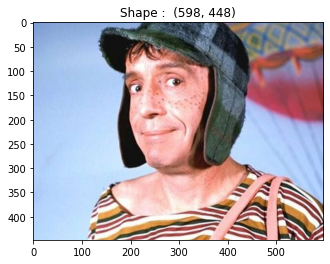

In [4]:
content_path = "/content/drive/MyDrive/OpenCV/Images/chaves.jpeg"
content_image = tf.keras.preprocessing.image.load_img(content_path)

plt.imshow(content_image)
plt.title(f"Shape :  {content_image.size}")
plt.show()

In [5]:
content_image.size, type(content_image)

((598, 448), PIL.JpegImagePlugin.JpegImageFile)

In [6]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)
content_image.shape, type(content_image)

((448, 598, 3), numpy.ndarray)

In [7]:
content_image.max(),content_image.min()

(255.0, 0.0)

In [8]:
content_image = content_image / 255
content_image.max(),content_image.min(),content_image.shape

(1.0, 0.0, (448, 598, 3))

In [9]:
content_image = content_image[tf.newaxis, :]
content_image.shape

(1, 448, 598, 3)

# Style Images

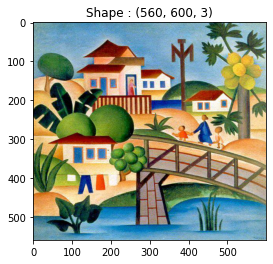

(1, 560, 600, 3)

In [12]:
style_path = "/content/drive/MyDrive/OpenCV/Images/tarsila_amaral.jpg"
style_image = tf.keras.preprocessing.image.load_img(style_path)
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255

plt.imshow(style_image)
plt.title(f"Shape : {style_image.shape}")
plt.show()

style_image = style_image[tf.newaxis, :]
style_image.shape

# Building The Neural Network

In [13]:
content_layers = ["block4_conv2"]
style_layers = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]

In [15]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
num_style_layers, num_content_layers

(5, 1)

In [16]:
[model.get_layer(name).output for name in style_layers]

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [19]:
model.inputs,model.input

([<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>],
 <KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>)

In [25]:
def vgg_layers(layers_name):

    vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layers_name]
    network = tf.keras.models.Model(inputs = [vgg.inputs], outputs = outputs)

    return network

In [26]:
style_extractor = vgg_layers(style_layers)
style_extractor.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [27]:
style_extractor.output,style_extractor.input

([<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
  <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
  <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
  <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
  <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>],
 [<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_3')>])

In [28]:
style_outputs = style_extractor(style_image)
len(style_outputs)

5

In [29]:
style_outputs[0].shape,style_outputs[1].shape,style_outputs[2].shape,style_outputs[3].shape,style_outputs[4].shape

(TensorShape([1, 560, 600, 64]),
 TensorShape([1, 280, 300, 128]),
 TensorShape([1, 140, 150, 256]),
 TensorShape([1, 70, 75, 512]),
 TensorShape([1, 35, 37, 512]))

In [30]:
# https://www.tensorflow.org/api_docs/python/tf/einsum

# Loss between the style and the content image (see original paper, section 2.2)

def gram_matrix(layer_activation):

    result = tf.linalg.einsum("bijc,bijd->bcd",layer_activation,layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)

    return result / num_locations

In [31]:
gram_matrix(style_outputs[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.631103  , 0.28949898, 0.28517228, ..., 0.1051826 ,
         0.36955735, 0.45017177],
        [0.28949898, 0.24226907, 0.18415499, ..., 0.03151667,
         0.19604628, 0.2170014 ],
        [0.28517228, 0.18415499, 0.16761073, ..., 0.02775798,
         0.19407691, 0.22697577],
        ...,
        [0.1051826 , 0.03151667, 0.02775798, ..., 0.08261998,
         0.06934635, 0.06634998],
        [0.36955735, 0.19604628, 0.19407691, ..., 0.06934635,
         0.28692862, 0.3186243 ],
        [0.45017177, 0.2170014 , 0.22697577, ..., 0.06634998,
         0.3186243 , 0.37485763]]], dtype=float32)>

In [40]:
class StyleContentModel(tf.keras.models.Model):

    def __init__(self,style_layers ,content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = num_style_layers
        self.vgg.trainable = False

    def call(self, inputs):

        inputs = inputs * 255
        # 0-1
        # -127.5, 127.5

        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name : value for content_name, value in zip(self.content_layers , content_outputs)}
        style_dict = {style_name : value for style_name, value in zip(self.style_layers , style_outputs)}

        return {"content" : content_dict ,"style" : style_dict}

In [41]:
style_layers,content_layers

(['block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1'],
 ['block4_conv2'])

In [42]:
content_image.shape

(1, 448, 598, 3)

In [43]:
extractor = StyleContentModel(style_layers ,content_layers)

In [ ]:
results = extractor(content_image)
results

In [45]:
len(results)

2

In [48]:
for key,value in results.items():
    print(key, ":", value.keys())

content : dict_keys(['block4_conv2'])
style : dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [49]:
style_image.shape,content_image.shape

((1, 560, 600, 3), (1, 448, 598, 3))

In [50]:
style_image.max(),style_image.min(),content_image.max(),content_image.min()

(1.0, 0.0, 1.0, 0.0)

In [55]:
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

In [56]:
len(style_targets),len(content_targets)

(5, 1)

In [57]:
optimizer = tf.optimizers.Adam(learning_rate = 0.02)

# Training

In [58]:
extractor = StyleContentModel(style_layers , content_layers)

style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

In [59]:
len(style_targets),len(content_targets)

(5, 1)

In [61]:
content_targets.keys()

dict_keys(['block4_conv2'])

In [ ]:
content_targets

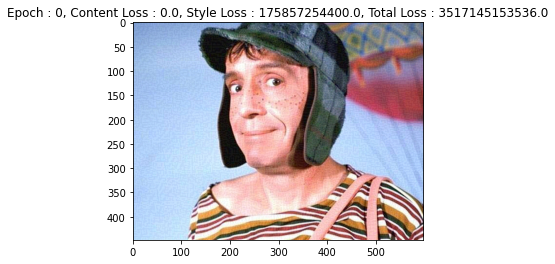

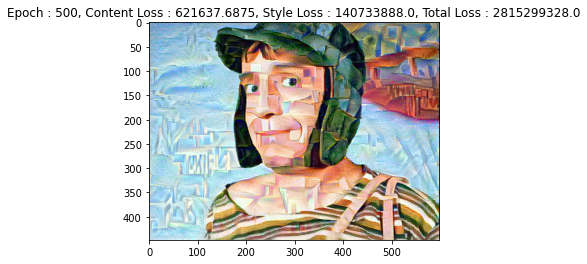

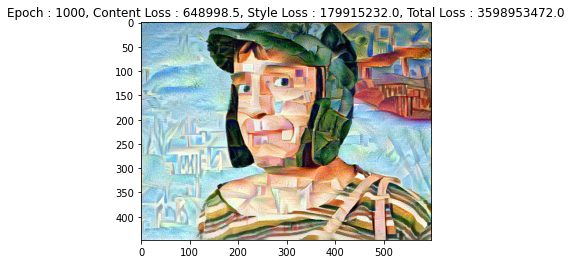

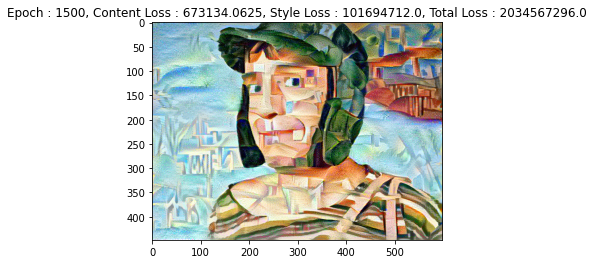

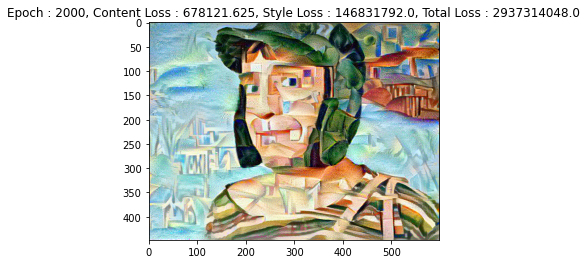

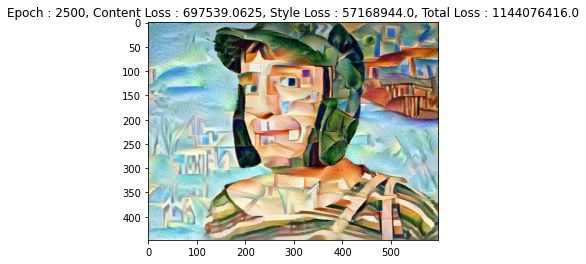

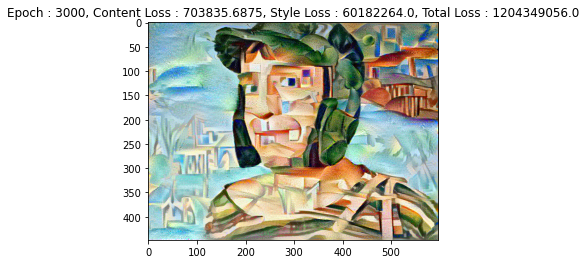

In [65]:
extractor = StyleContentModel(style_layers , content_layers)

# Ayrı ayrı bir oluşturduk
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

new_image = tf.Variable(content_image)

content_weight = 1
style_weight = 100

epochs = 3000
print_every = 500

for epoch in range(epochs + 1):

    with tf.GradientTape() as tape:

        outputs = extractor(new_image)

        content_outputs = outputs["content"]
        style_outputs = outputs["style"]

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])

        total_loss = content_loss * content_weight / num_content_layers + style_loss * style_weight / num_style_layers

    gradient = tape.gradient(total_loss,new_image)
    optimizer.apply_gradients([(gradient, new_image)])

    new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

    if epoch % print_every == 0:

        plt.imshow(tf.squeeze(new_image, axis = 0))
        plt.title(f"Epoch : {epoch}, Content Loss : {content_loss}, Style Loss : {style_loss}, Total Loss : {total_loss}")
        plt.show()

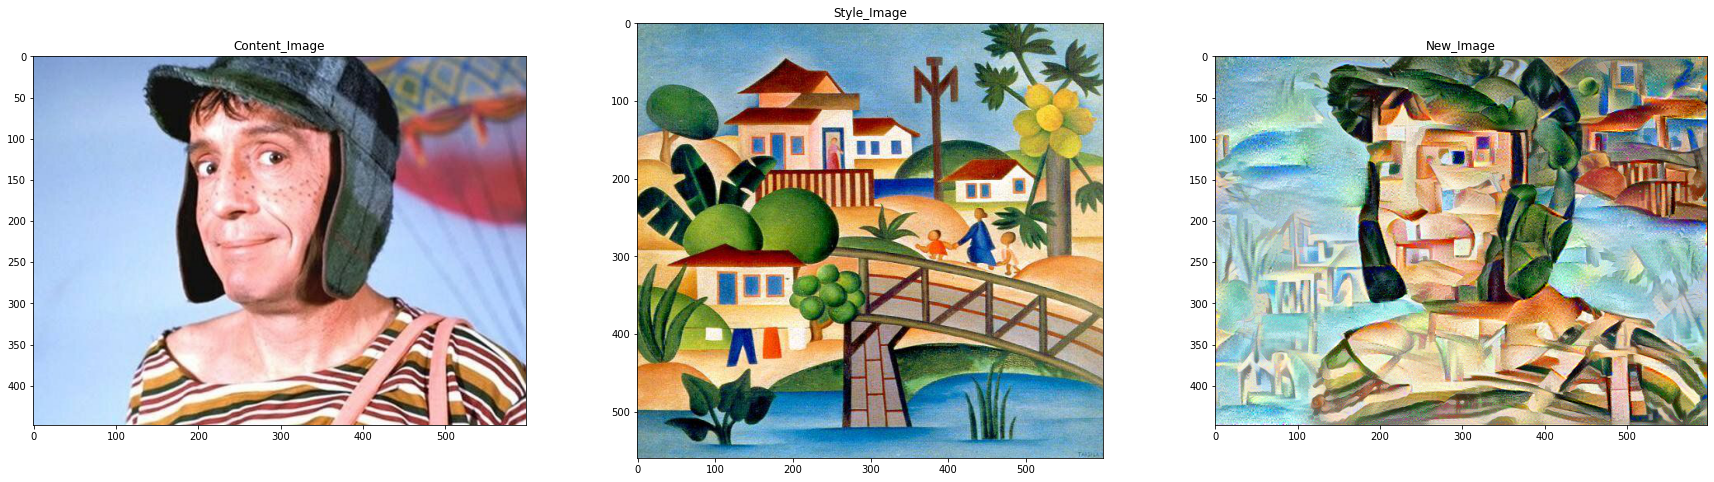

In [67]:
fig, (axes1,axes2,axes3) = plt.subplots(1,3, figsize = (30,8))

axes1.imshow(tf.squeeze(content_image, axis = 0))
axes1.set_title("Content_Image")

axes2.imshow(tf.squeeze(style_image, axis = 0))
axes2.set_title("Style_Image")

axes3.imshow(tf.squeeze(new_image, axis = 0))
axes3.set_title("New_Image")

plt.show()

# HomeWork And Summary

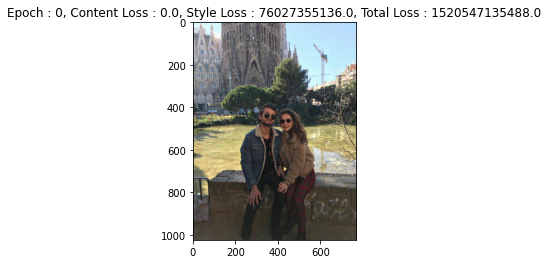

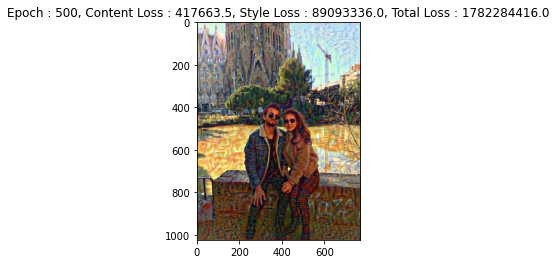

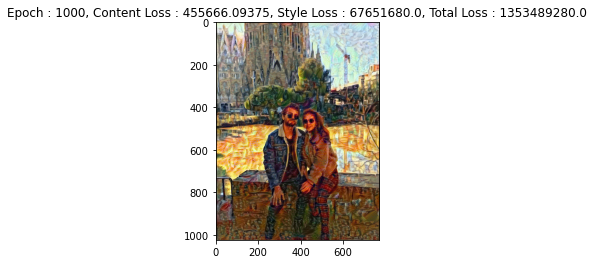

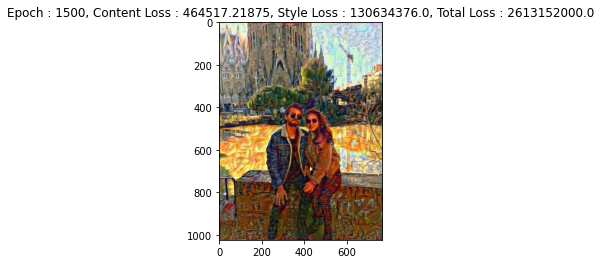

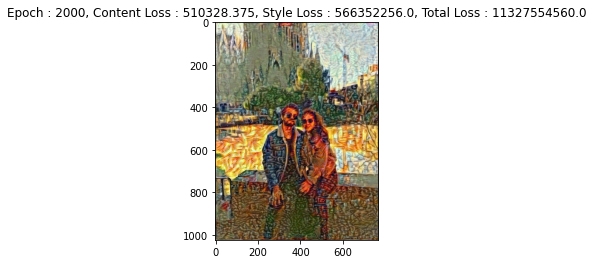

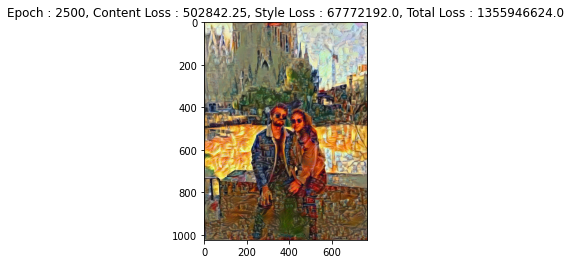

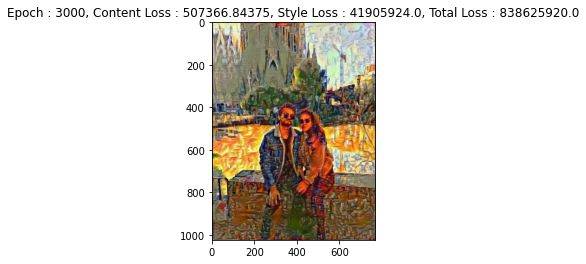

In [74]:
import tensorflow as tf

content_path = "/content/drive/MyDrive/pg.JPG"
style_path = "/content/drive/MyDrive/prag.jpg"

def change_image(image_path):

    image = tf.keras.preprocessing.image.load_img(image_path)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255
    image = image[tf.newaxis,:]

    return image

style_image = change_image(style_path)
content_image = change_image(content_path)

content_layers = ["block4_conv2"]
style_layers = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):

    vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    network = tf.keras.models.Model(inputs = vgg.input, outputs =outputs)

    return network

def gram_matrix(layer_activation):

    result = tf.linalg.einsum("bijc,bijd->bcd",layer_activation,layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)

    return result / num_locations

class StyleContentModel(tf.keras.models.Model):

    def __init__(self,style_layers , content_layers):

        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = num_style_layers
        self.vgg.trainable = False

    def call(self, image):

        image = image * 255

        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(image)
        outputs = self.vgg(preprocessed_input)

        style_outputs = outputs[:self.num_style_layers ]
        content_outputs = outputs[self.num_style_layers: ]

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name : value for content_name, value in zip(content_layers, content_outputs)}
        style_dict = {style_name : value for style_name, value in zip(style_layers, style_outputs)}

        return {"content" : content_dict, "style" : style_dict}



extractor = StyleContentModel(style_layers, content_layers)

content_targets = extractor(content_image)["content"]
style_targets = extractor(style_image)["style"]

content_weights = 1
style_weights = 100

print_every = 500
epochs = 3000

new_image = tf.Variable(content_image)
optimizer = tf.optimizers.Adam(learning_rate = 0.02)

for epoch in range(epochs + 1):
 
    with tf.GradientTape() as tape:

        outputs = extractor(new_image)

        style_outputs = outputs["style"]
        content_outputs = outputs["content"]

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])

        total_loss = content_loss * content_weights / num_content_layers + style_loss * style_weights / num_style_layers

    gradient = tape.gradient(total_loss, new_image)
    optimizer.apply_gradients([(gradient, new_image)])

    new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

    if (epoch) % print_every == 0:

        plt.imshow(tf.squeeze(new_image, axis = 0))
        plt.title(f"Epoch : {epoch}, Content Loss : {content_loss}, Style Loss : {style_loss}, Total Loss : {total_loss}")
        plt.show()

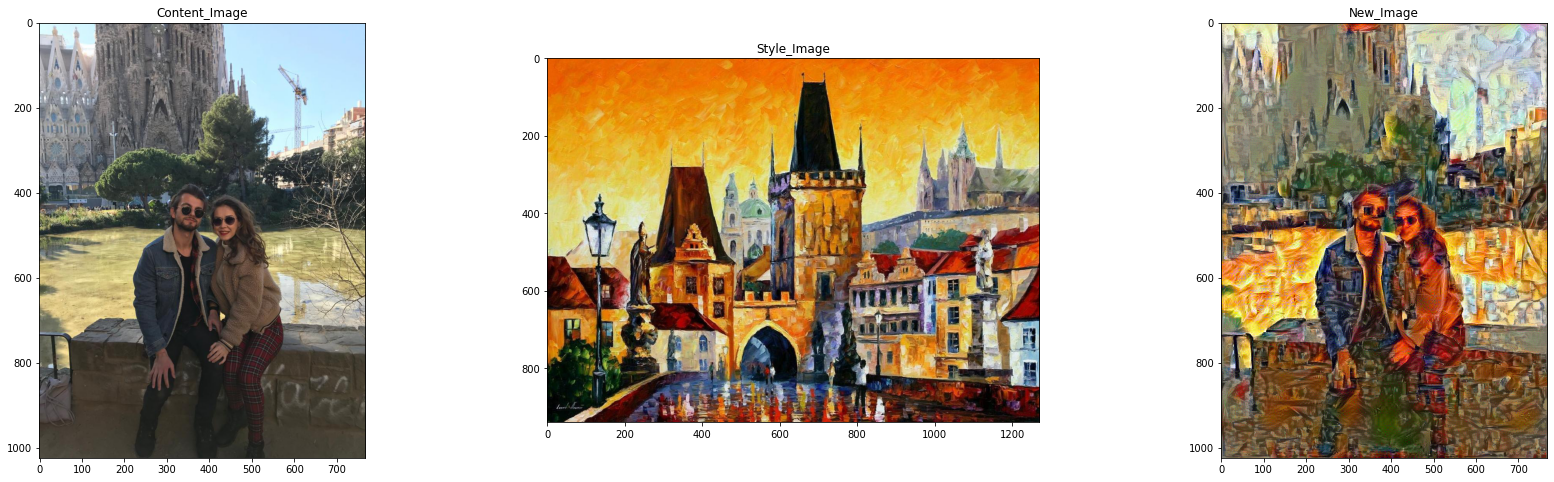

In [75]:
fig, (axes1,axes2,axes3) = plt.subplots(1,3, figsize = (30,8))

axes1.imshow(tf.squeeze(content_image, axis = 0))
axes1.set_title("Content_Image")

axes2.imshow(tf.squeeze(style_image, axis = 0))
axes2.set_title("Style_Image")

axes3.imshow(tf.squeeze(new_image, axis = 0))
axes3.set_title("New_Image")

plt.show()